In [3]:
!unzip /content/capcha.zip -d chap

Archive:  /content/capcha.zip
  inflating: chap/samples/226md.png  
  inflating: chap/samples/22d5n.png  
  inflating: chap/samples/2356g.png  
  inflating: chap/samples/23mdg.png  
  inflating: chap/samples/23n88.png  
  inflating: chap/samples/243mm.png  
  inflating: chap/samples/244e2.png  
  inflating: chap/samples/245y5.png  
  inflating: chap/samples/24f6w.png  
  inflating: chap/samples/24pew.png  
  inflating: chap/samples/25257.png  
  inflating: chap/samples/253dc.png  
  inflating: chap/samples/25egp.png  
  inflating: chap/samples/25m6p.png  
  inflating: chap/samples/25p2m.png  
  inflating: chap/samples/25w53.png  
  inflating: chap/samples/264m5.png  
  inflating: chap/samples/268g2.png  
  inflating: chap/samples/28348.png  
  inflating: chap/samples/28x47.png  
  inflating: chap/samples/2b827.png  
  inflating: chap/samples/2bg48.png  
  inflating: chap/samples/2cegf.png  
  inflating: chap/samples/2cg58.png  
  inflating: chap/samples/2cgyx.png  
  inflating: chap/sa

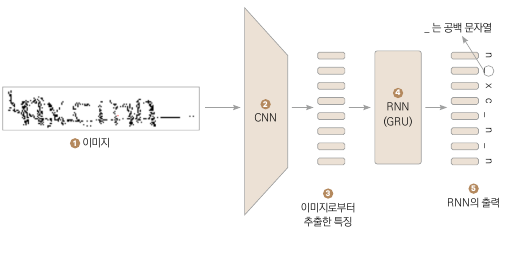

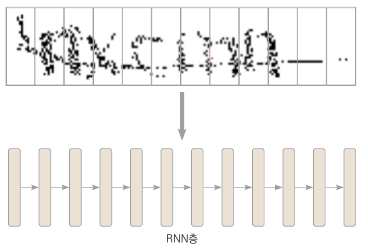

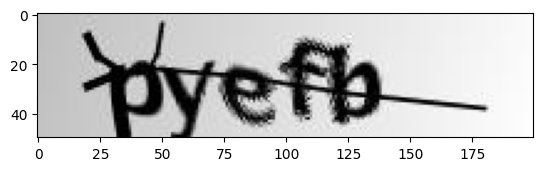

In [4]:
import matplotlib.pyplot as plt
import tqdm
from PIL import Image
import glob
imgfiles = glob.glob('/content/chap/samples/samples/*.*')
img =  Image.open(imgfiles[0])
plt.imshow(img)
plt.show()

In [5]:
imgfiles[0]

'/content/chap/samples/samples/pyefb.png'

png
  - RGB, 투명도를 나타내는 alpha 값이 존재

# 파일명(정답) BOW 구조로 만듦

In [35]:
import numpy as np

from torch.utils.data.dataset import Dataset


# 문자들로부터 BOW를 만드는 함수
def get_BOW(corpus):
   # 공백문자 <pad>를 0으로 설정
   BOW = {"<pad>":0}

   # corpus의 문자들을 이용해 BOW에 고유번호 추가
   for letter in corpus:
       if letter not in BOW.keys():
           BOW[letter] = len(BOW.keys())

   return BOW


class Captcha(Dataset):
   def __init__(self, pth, train=True):
       # 소문자와 숫자만 정답으로 이용
       self.corpus = string.ascii_lowercase + string.digits
       self.BOW = get_BOW(self.corpus)

       # 불러올 이미지 파일의 경로
       self.imgfiles = glob.glob(pth+"/*.png")

       self.train = train
       self.trainset = self.imgfiles[:int(len(self.imgfiles)*0.8)]
       self.testset = self.imgfiles[int(len(self.imgfiles)*0.8):]

   # 문자와 숫자를 고유번호로 치환
   def get_seq(self, line):
       label = []
       for letter in line:
           label.append(self.BOW[letter])
       return label

   def __len__(self):
       if self.train:
           return len(self.trainset)
       else:
           return len(self.testset)

   def __getitem__(self, i):
       if self.train:
           # png파일을 RGB파일로 변환
           data = Image.open(self.trainset[i]).convert("RGB")

           label = self.trainset[i].split("/")[-1]
           # 파일이름에서 확장자를 제거
           label = label.split(".png")[0]
           # 정답 문자열을 BOW의 순열로 변환
           label = self.get_seq(label)

           data = np.array(data).astype(np.float32)
           # 파이토치는 채널이 가장 앞에 와야 함
           data = np.transpose(data, (2, 0, 1))
           label = np.array(label)

           return data, label

       else:
           data = Image.open(self.testset[i]).convert("RGB")
           label = self.testset[i].split("/")[-1]
           label = label.split(".png")[0]
           label = self.get_seq(label)

           data = np.array(data).astype(np.float32)
           label = np.array(label)

           return data, label

In [36]:
np.array(Image.open(imgfiles[0]).convert('RGB')).shape

(50, 200, 3)

In [37]:
import string
string.ascii_lowercase, string.punctuation, string.ascii_letters, string.digits

('abcdefghijklmnopqrstuvwxyz',
 '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ',
 '0123456789')

- CNN 이미지는 가로세로가 거의 동일
- 가로의 길이가 좀더 긴 형태



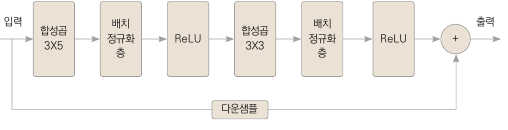

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [44]:
# 3 x 5
class BasicBlock(nn.Module):
  def __init__(self, in_channels,out_channels,kernel_size=(3,5),stride=(2,1)):
    super(BasicBlock,self).__init__()
    self.c1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels
                           ,kernel_size=kernel_size,stride=stride)
    self.c2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels
                           ,kernel_size=(3,3),padding=1)
    self.downsample = nn.Conv2d(in_channels=in_channels,out_channels=out_channels
                           ,kernel_size=kernel_size,stride=stride)
    self.bn1 = nn.BatchNorm2d(num_features=out_channels)
    self.bn2 = nn.BatchNorm2d(num_features=out_channels)
    self.relu = nn.ReLU()
  def forward(self,x):
    x_ = x
    x = self.c1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.c2(x)
    x = self.bn2(x)

    x_ = self.downsample(x_)
    x += x_
    x = self.relu(x)
    return x

CRNN모델은 GRU모델을 사용
  - GRU 에서 나온 데이터는 MLP층을 통과해서 어떤 글자인지 분류

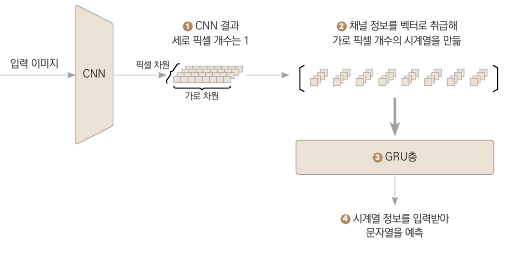

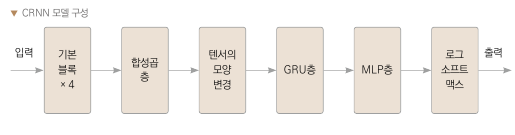

In [45]:
class CRNN(nn.Module):
  def __init__(self,out_size):
    super(CRNN,self).__init__()
    # cnn층 정리
    self.c1 = BasicBlock(3,64)
    self.c2 = BasicBlock(64,64)
    self.c3 = BasicBlock(64,64)
    self.c4 = BasicBlock(64,64)
    self.c5 = nn.Conv2d(64,64,kernel_size=(2,5))
    # 텍스트 정보추출
    self.gru = nn.GRU(64,64,batch_first=False)
    # 결과 MLP
    self.fc1 = nn.Linear(64,128)
    self.fc2 = nn.Linear(128,out_size)
    self.relu = nn.ReLU()
  def forward(self,x):
    # (B, 3,50,200)
    x = self.c1(x)
    x = self.c2(x)
    x = self.c3(x)
    x = self.c4(x)
    x = self.c5(x)

    x = x.view(x.shape[0],64,-1)
    x = x.permute(2,0,1)

    x,_ = self.gru(x)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    x = F.log_softmax(x,dim=-1)
    return x

In [46]:
from torch.optim.adam import Adam
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else 'cpu'

dataset = Captcha('/content/chap/samples/samples')
loader = DataLoader(dataset, batch_size=8)

model = CRNN(out_size = len(dataset.BOW)).to(device)
optim =Adam(model.parameters(), lr=1e-4)

In [42]:
for epoch in range(200):
  iterdata = tqdm.tqdm(loader)
  for data, label in iterdata:
    optim.zero_grad()
    preds = model(data.to(device))
    pred_size = torch.IntTensor([preds.size(0)]*8).to(device)
    target_len = torch.IntTensor([len(txt) for txt in label]).to(device)
    #손실계산
    loss = nn.CTCLoss(blank=0)(
        preds,label.to(device),pred_size,target_len
    )
    loss.backward()
    optim.step()
    iterdata.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(model.state_dict(), "CRNN.pth")


epoch:9 loss:3.470611810684204: 100%|██████████| 104/104 [00:02<00:00, 34.91it/s]


평가

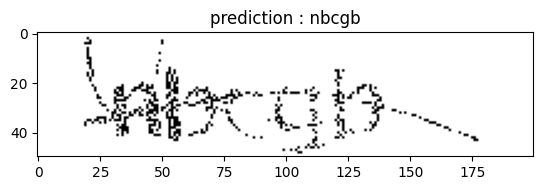

In [48]:
model.load_state_dict(torch.load("CRNN.pth",map_location=device))
with torch.no_grad():
  testdataset = Captcha('/content/chap/samples/samples', train=False)
  test_img , label = testdataset[100]
  input_tensor = torch.unsqueeze(torch.tensor(test_img),dim=0)
  input_tensor = input_tensor.permute(0,3,1,2).to(device)
  pred = torch.argmax(model(input_tensor),dim=-1)
  # 글자간의 중복제거
  prev_letter = pred[0].item()
  pred_word = ""
  for letter in pred:
    if letter.item() !=0 and letter.item() != prev_letter:
      pred_word += list(testdataset.BOW.keys())[letter.item()]
    prev_letter = letter.item()
  plt.imshow(test_img)
  plt.title(f"prediction : {pred_word}")
  plt.show()
